In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np
from pyproj import Proj, transform
import contextily as ctx
from shapely.geometry import box
import fiona

/var/folders/gr/g6k4s8t13n98c8bw4ywdpxrr0000gn/T/ipykernel_38958/654209686.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
# Path to your file geodatabase
gdb_path = "../data/raw/ICADisplay.gdb"

# List all layers
layers = fiona.listlayers(gdb_path)
print(layers)

['LineDetail', 'ICANotAvailable', 'FeederDetail', 'Substations', 'FeederLoadProfile', 'SubstationLoadProfile', 'TransmissionLines', 'networkedSecondaryBuffer', 'FeederSubstationSummary', 'ICAEstimatedCapacitySummary']


In [3]:
# Load and prepare the data
feederinfo = gpd.read_file("../data/raw/ICADisplay.gdb", driver='fileGDB', layer="FeederDetail")
circinfo = gpd.read_file("../data/raw/ICADisplay.gdb", driver='fileGDB', layer="LineDetail") # , ignore_geometry=True) # FeederDetail
subinfo = gpd.read_file("../data/raw/ICADisplay.gdb", driver='fileGDB', layer="Substations") # , ignore_geometry=True)
circload = gpd.read_file("../data/raw/ICADisplay.gdb", driver='fileGDB', layer="FeederLoadProfile") # , ignore_geometry=True)
subload = gpd.read_file("../data/raw/ICADisplay.gdb", driver='fileGDB', layer="SubstationLoadProfile") # , ignore_geometry=True)
# Section data??

# # Check if sample values in circica_filtered exist in feederinfo
# sample_values_exist = circinfo['FeederId'].isin(feederinfo['FeederID']).any()

# # Print out the result
# print(sample_values_exist)

# Data Processing
# Calculate the maximum reported load capacity (ICA) for each feeder by grouping the feeder data by feeder ID and taking the maximum load capacity. Sort the categories of FeederId based on this maximum load capacity.
circica = circinfo[['FeederId', 'CSV_LineSection', 'LoadCapacity_kW']].groupby('FeederId').agg(
    IC_LoadLimit_Rall_kW=pd.NamedAgg(column='LoadCapacity_kW', aggfunc='max')
).reset_index()
circica['FeederId'] = pd.Categorical(circica['FeederId'], categories=pd.Categorical(circica['FeederId']).categories[::-1], ordered=True)

# Save to CSV
circica.to_csv("../data/clean/circica.csv", index=False)
circica.dtypes.to_frame().T.to_csv("../data/clean/circica_cls.csv", index=False)

circica.columns.count()

True


AttributeError: 'Index' object has no attribute 'count'

In [ ]:
# Print names of columns
dataframes = {
    'feederinfo': feederinfo,
    'circinfo': circinfo,
    'subinfo': subinfo,
    'circload': circload,
    'subload': subload
}

# Printing column keys in a table format
for name, df in dataframes.items():
    print(f"DataFrame: {name}")
    print(df.columns.tolist())
    print()

DataFrame: feederinfo
['Substation', 'FeederID', 'Feeder_Name', 'Nominal_Voltage', 'Load_Profile_Redaction', 'ResCust', 'ComCust', 'IndCust', 'AgrCust', 'OthCust', 'Existing_DG', 'Queued_DG', 'Total_DG', 'Show', 'VOLTNUM', 'Shape_Length', 'geometry']

DataFrame: circinfo
['FeederId', 'FeederName', 'Globalid', 'CSV_LineSection', 'ICA_Analysis_Date', 'LoadCapacity_kW', 'GenCapacity_kW', 'GenericPVCapacity_kW', 'GenCapacity_no_OpFlex_kW', 'GenericCapacity_no_OpFlex_kW', 'Shape_Length', 'geometry']

DataFrame: subinfo
['SUBNAME', 'SUBSTATIONID', 'MIN_KV', 'NUMBANKS', 'REDACTED', 'OBJECTID', 'UNGROUNDEDBANKS', 'geometry']

DataFrame: circload
['FeederID', 'MonthHour', 'Light', 'High', 'geometry']

DataFrame: subload
['SubName', 'SubID', 'MonthHour', 'Light', 'High', 'geometry']



In [ ]:
subinfo.head()

,SUBNAME,SUBSTATIONID,MIN_KV,NUMBANKS,REDACTED,OBJECTID,UNGROUNDEDBANKS,geometry
0,COLONY,16223,12.0,1.0,No,65209,None,POINT (659291.084 4228515.386)
1,LAYTONVILLE,4268,12.0,1.0,No,161558,None,POINT (459092.706 4392898.016)
2,MORRO BAY,18301,12.0,1.0,No,49004,None,POINT (694796.042 3916669.448)
3,CABRILLO,18310,12.0,1.0,No,49006,None,POINT (734883.480 3836467.184)
4,RIVER OAKS,8234,21.0,2.0,Yes,49007,None,POINT (594949.555 4141038.926)


In [ ]:
feederinfo['geometry'].head()

0    MULTILINESTRING ((592261.255 4250204.183, 5922...
1    MULTILINESTRING ((564225.965 4183386.053, 5642...
2    MULTILINESTRING ((544321.595 4190204.063, 5443...
3    MULTILINESTRING ((623924.545 4056135.993, 6239...
4    MULTILINESTRING ((592530.865 4372162.253, 5925...
Name: geometry, dtype: geometry

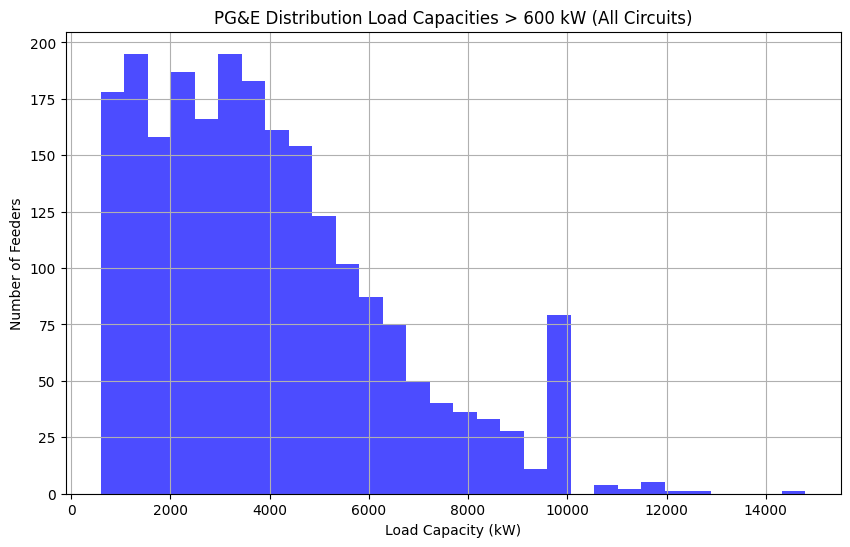

In [ ]:
# Plotting
plt.figure(figsize=(6, 4))
plt.bar(circica['FeederId'], circica['IC_LoadLimit_Rall_kW'], color='lightblue')
plt.xlabel('Circuit')
plt.ylabel('Max Remaining Load Capacity (kW)')
plt.savefig("../data/figures/PGEcircmaxload.png")
plt.close()

# # Total available load capacity
# total_capacity = circica['LoadCapacity_kW'].sum()
# print(f"Total available load capacity: {total_capacity} kW")

# # Average load capacity
# average_capacity = circica['LoadCapacity_kW'].mean()
# print(f"Average load capacity: {average_capacity} kW")

load_threshold = 600 # kW
mask = circica['IC_LoadLimit_Rall_kW'] >= load_threshold

circica_helper = circica[mask]

# Remaining capacity
plt.figure(figsize=(10, 6))
plt.hist(circica_helper['IC_LoadLimit_Rall_kW'], bins=30, color='blue', alpha=0.7)
plt.title('PG&E Distribution Load Capacities > 600 kW (All Circuits)')
plt.xlabel('Load Capacity (kW)')
plt.ylabel('Number of Feeders')
plt.grid(True)
plt.show()

In [ ]:
feederinfo.head()

,Substation,FeederID,Feeder_Name,Nominal_Voltage,Load_Profile_Redaction,ResCust,ComCust,IndCust,AgrCust,OthCust,Existing_DG,Queued_DG,Total_DG,Show,VOLTNUM,Shape_Length,geometry
0,VACA DIXON,063591102,VACA DIXON 1102,12kV,Yes,1433,101,24,0,6,8280,5770,14050,1,12.00,26933.320905,"MULTILINESTRING ((592261.255 4250204.183, 5922..."
1,OAKLAND C,012011114,OAKLAND C 1114,12kV,No,2242,274,138,3,20,1320,590,1910,1,12.00,11458.048102,"MULTILINESTRING ((564225.965 4183386.053, 5642..."
2,SAUSALITO,042490402,SAUSALITO 0402,4.16kV,Yes,523,8,1,0,0,360,160,520,1,4.16,5054.876335,"MULTILINESTRING ((544321.595 4190204.063, 5443..."
3,BUENA VISTA,182261106,BUENA VISTA 1106,12kV,Yes,14,25,18,49,1,200,200,400,1,12.00,23941.399005,"MULTILINESTRING ((623924.545 4056135.993, 6239..."
4,RICE,062831101,RICE 1101,12kV,Yes,79,36,5,129,2,1140,1640,2780,1,12.00,87963.924972,"MULTILINESTRING ((592530.865 4372162.253, 5925..."


In [ ]:
# How many feeders have less than 100 kW in capacity, and how many customers are served by those feeders?

load_threshold = 100 # kW
# Filter circica DataFrame for feeders with less than 100 kW
circica_filtered = circica[circica['IC_LoadLimit_Rall_kW'] <= load_threshold]

# Perform a left join between circica_filtered and feederinfo on 'FeederID'
merged_data = pd.merge(circica_filtered, feederinfo, how='left', left_on='FeederId', right_on='FeederID')

merged_data.head()
# # Select Feeder_Name, TotCust, and geometry columns
# result = merged_data[['Feeder_Name', 'TotCust', 'geometry', 'IC_LoadLimit_Rall_kW']]

# print(result.head())

# # Convert to GeoDataFrame
# result_geo = gpd.GeoDataFrame(result, geometry='geometry')
# # Now 'result_geo' contains the desired columns (Feeder_Name, TotCust, and geometry) for feeders with less than 100 kW

# print(result_geo.head())

,FeederId,IC_LoadLimit_Rall_kW,Substation,FeederID,Feeder_Name,Nominal_Voltage,Load_Profile_Redaction,ResCust,ComCust,IndCust,AgrCust,OthCust,Existing_DG,Queued_DG,Total_DG,Show,VOLTNUM,Shape_Length,geometry
0,012011109,0,OAKLAND C,012011109,OAKLAND C 1109,12kV,Yes,3195.0,357.0,127.0,0.0,26.0,6850.0,390.0,7240.0,1.0,12.00,19633.122490,"MULTILINESTRING ((563554.975 4183280.753, 5635..."
1,012011113,0,OAKLAND C,012011113,OAKLAND C 1113,12kV,Yes,1450.0,214.0,76.0,0.0,27.0,350.0,400.0,750.0,1.0,12.00,13982.352541,"MULTILINESTRING ((563297.995 4183606.423, 5632..."
2,012011119,0,OAKLAND C,012011119,OAKLAND C 1119,12kV,Yes,0.0,3.0,3.0,0.0,1.0,3400.0,0.0,3400.0,1.0,12.00,2618.321446,"MULTILINESTRING ((561585.155 4183274.843, 5615..."
3,012040410,0,OAKLAND D,012040410,OAKLAND D 0410,4.16kV,No,835.0,54.0,9.0,0.0,2.0,380.0,150.0,530.0,1.0,4.16,5171.839817,"MULTILINESTRING ((564813.775 4188025.693, 5648..."
4,012041130,0,OAKLAND D,012041130,OAKLAND D 1130,12kV,Yes,1802.0,197.0,64.0,0.0,8.0,11080.0,6310.0,17390.0,1.0,12.00,13678.347404,"MULTILINESTRING ((562777.315 4189608.253, 5627..."


TypeError: Cannot cast array data from dtype('float64') to dtype('int64') according to the rule 'safe'

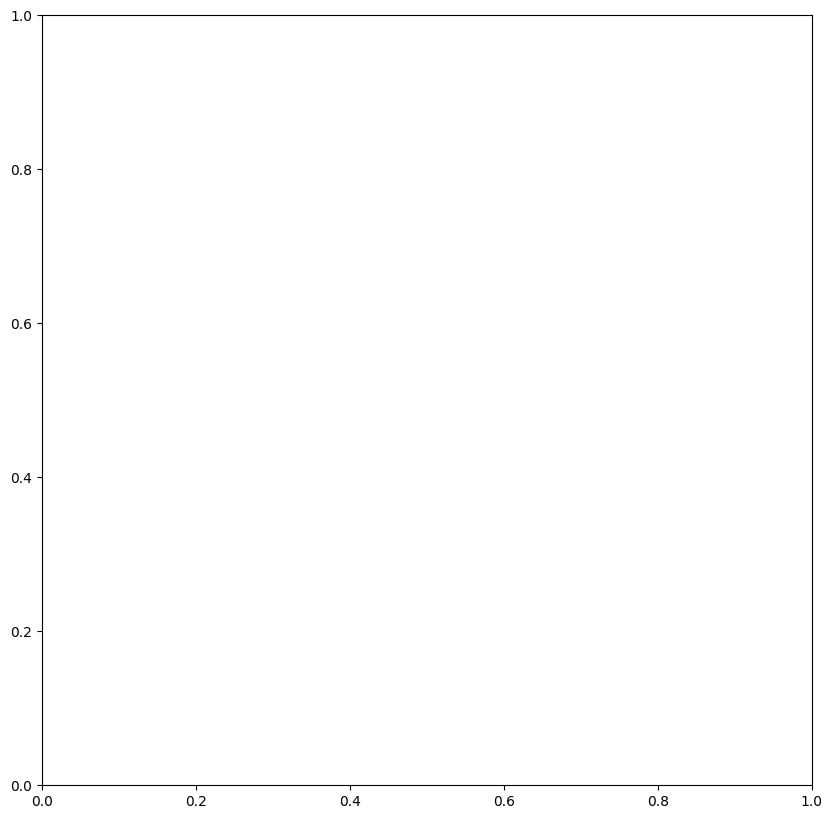

In [ ]:
# Select the top 5 feeders with non-zero capacity
top_feeders = result_geo[result_geo['IC_LoadLimit_Rall_kW'] > 0].nlargest(5, 'IC_LoadLimit_Rall_kW')

# Plot the feeders
fig, ax = plt.subplots(figsize=(10, 10))
top_feeders.plot(ax=ax, column='TotCust', legend=True, legend_kwds={'label': 'Number of Customers'}, markersize=100)

# Add legend with number of customers
# Get the handles and labels of the legend
handles, labels = ax.get_legend_handles_labels()
# Create a new legend with the number of customers
ax.legend(handles, [f'{label} ({int(top_feeders[top_feeders["Feeder_Name"]==label]["TotCust"])} customers)' for label in labels], title="Number of Customers")

# Add basemap if needed
# ctx.add_basemap(ax, crs=result_geo.crs)

# Set title and labels
plt.title('Top 5 Feeders with Non-zero Capacity')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.show()

# Summarize results in a table
summary_table = top_feeders[['Feeder_Name', 'TotCust', 'IC_LoadLimit_Rall_kW']].copy()
print(summary_table)

In [ ]:
# Month-hour data
# Creating new DataFrame for month-hour data with explicit data types
mh = pd.DataFrame({
    'Month': np.repeat(np.arange(1, 13), 24).astype(int),
    'Hour': np.tile(np.arange(24), 12).astype(int)
})
mh['mhid'] = pd.RangeIndex(start=1, stop=len(mh)+1)  # Starting index from 1 for clarity

# Preprocessing circload DataFrame
# Extracting Month and Hour from 'MonthHour' column and converting to integer type
circload['Month'] = circload['MonthHour'].str.slice(0, 2).astype(int)
circload['Hour'] = circload['MonthHour'].str.slice(3, 5).astype(int)

# Renaming columns for clarity and consistency
circload.rename(columns={'Light': 'Light_kW', 'High': 'High_kW'}, inplace=True)

# Performing an outer merge and sorting by 'Month' and 'Hour'
# Handling potential duplicate column names by specifying suffixes
merged_df = pd.merge(circload, mh, on=['Month', 'Hour'], how='outer', sort=True, suffixes=('_cl', '_mh'))

# print(merged_df.head())

# print(feederinfo.keys())

feederinfo['TotCust'] = feederinfo[['ResCust', 'ComCust', 'IndCust', 'AgrCust', 'OthCust']].sum(axis=1)
for col in ['ResCust', 'ComCust', 'IndCust', 'AgrCust', 'OthCust']:
    feederinfo[col+'_pct'] = feederinfo[col] / feederinfo['TotCust'] * 100

print("Total customers on feeder:")
# print(feederinfo['Feeder_Name'])
# print(feederinfo['TotCust'])

# print(feederinfo.keys())
# print(circload.keys())

# Convert 'FeederID' to int in both dataframes before merging
circload['FeederID'] = circload['FeederID'].astype(int)
feederinfo['FeederID'] = feederinfo['FeederID'].astype(int)

circload = circload.merge(
    feederinfo[['Substation', 'FeederID', 'Feeder_Name', 'Nominal_Voltage', # 'Load_Profile',
              'ResCust', 'ComCust', 'IndCust', 'AgrCust', 'OthCust', 'TotCust',
              'Existing_DG', 'Queued_DG', 'Total_DG']],
    on='FeederID', how='left'
)

circload.keys()

print(f"DataFrame: circload")
print(circload.columns.tolist())


Total customers on feeder:


MergeError: Passing 'suffixes' which cause duplicate columns {'IndCust_x', 'ComCust_x', 'Queued_DG_x', 'OthCust_x', 'TotCust_x', 'Existing_DG_x', 'Feeder_Name_x', 'AgrCust_x', 'ResCust_x', 'Nominal_Voltage_x', 'Total_DG_x', 'Substation_x'} is not allowed.

In [ ]:
# Assuming 'TotCust' represents the total number of customers each feeder serves
top_feeders = feederinfo.nlargest(5, 'TotCust')[['Feeder_Name', 'TotCust', 'geometry']]
print(top_feeders)


           Feeder_Name  TotCust  \
1616         MESA 1103     7814   
2824    OAKLAND J 1116     7688   
2051  MISSION (X) 1113     7472   
667     OAKLAND X 1115     7471   
1881         SF H 1105     7365   

                                               geometry  
1616  MULTILINESTRING ((-44894.793 -333956.777, -448...  
2824  MULTILINESTRING ((-194240.681 -24687.746, -194...  
2051  MULTILINESTRING ((-214484.502 -24623.513, -214...  
667   MULTILINESTRING ((-197774.565 -18747.183, -197...  
1881  MULTILINESTRING ((-216445.417 -32563.502, -216...  


In [ ]:
bounds_bay_area_x = [-122.8, -121.7]
bounds_bay_area_y = [37.5, 38.1]

In [ ]:
# City Boundaries
# Data source:
census_tracts = gpd.read_file("../data/raw/tl_2023_06_tract", layer="tl_2023_06_tract") # ctys

census_tracts

# STATEFP: The State FIPS (Federal Information Processing Standard) code, which is a two-digit code that uniquely identifies each U.S. state.
# COUNTYFP: The County FIPS code, a three-digit code that, when combined with the State FIPS code, uniquely identifies a county within the United States.
# TRACTCE: The Census Tract code, which is a statistical geographic area designed to be relatively homogenous in population characteristics, economic status, and living conditions.
# GEOID: A concatenation of the STATEFP, COUNTYFP, and TRACTCE codes, creating a unique identifier for each census tract within the nation.
# GEOIDFQ: Likely stands for 'GEOID Fully Qualified', another format of a unique identifier for the geographic entity.
# NAME: The basic or short name of the geographic entity, which is the census tract number in this context.
# NAMELSAD: The name and the legal/statistical area description for the tract (e.g., Census Tract 4427).
# MTFCC: The MAF/TIGER Feature Class Code, which describes the type of feature represented by the record (G5020 typically denotes an area feature such as a census tract).
# FUNCSTAT: Functional status of the entity, which describes whether the geographic entity is active and functioning (e.g., 'S' for statistical).
# ALAND: Land area in square meters.
# AWATER: Water area in square meters.
# INTPTLAT: The latitude of the internal point (or centroid) of the feature.
# INTPTLON: The longitude of the internal point (or centroid) of the feature.
# geometry: The geometric data that defines the shape of the feature, which in this case is a polygon representing the boundaries of the census tract.

,STATEFP,COUNTYFP,TRACTCE,GEOID,GEOIDFQ,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,06,001,442700,06001442700,1400000US06001442700,4427,Census Tract 4427,G5020,S,1234016,0,+37.5371513,-122.0081095,"POLYGON ((-122.01721 37.53932, -122.01719 37.5..."
1,06,001,442800,06001442800,1400000US06001442800,4428,Census Tract 4428,G5020,S,1278646,0,+37.5293619,-121.9931002,"POLYGON ((-122.00230 37.52984, -122.00224 37.5..."
2,06,037,204920,06037204920,1400000US06037204920,2049.20,Census Tract 2049.20,G5020,S,909972,0,+34.0175004,-118.1974975,"POLYGON ((-118.20284 34.01966, -118.20283 34.0..."
3,06,037,205110,06037205110,1400000US06037205110,2051.10,Census Tract 2051.10,G5020,S,286962,0,+34.0245059,-118.2142985,"POLYGON ((-118.21963 34.02629, -118.21945 34.0..."
4,06,037,320101,06037320101,1400000US06037320101,3201.01,Census Tract 3201.01,G5020,S,680504,0,+34.2992784,-118.4326573,"POLYGON ((-118.43882 34.29911, -118.43732 34.3..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9124,06,059,001303,06059001303,1400000US06059001303,13.03,Census Tract 13.03,G5020,S,1179647,0,+33.9209014,-117.9511671,"POLYGON ((-117.95917 33.92458, -117.95888 33.9..."
9125,06,059,001304,06059001304,1400000US06059001304,13.04,Census Tract 13.04,G5020,S,1252716,0,+33.9244375,-117.9455411,"POLYGON ((-117.95918 33.92820, -117.95831 33.9..."
9126,06,059,001401,06059001401,1400000US06059001401,14.01,Census Tract 14.01,G5020,S,1592982,15869,+33.9408240,-117.9410039,"POLYGON ((-117.95056 33.94503, -117.95055 33.9..."
9127,06,013,367200,06013367200,1400000US06013367200,3672,Census Tract 3672,G5020,S,1322255,0,+37.9660275,-122.3355517,"POLYGON ((-122.34551 37.96355, -122.34550 37.9..."


EPSG:4269


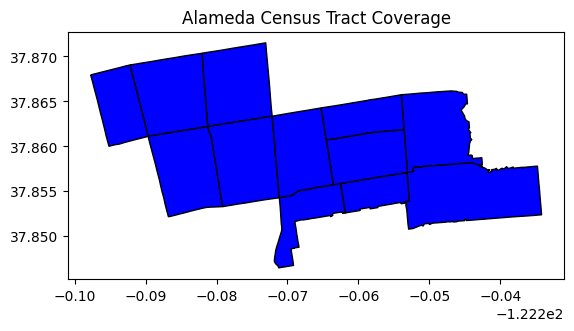

In [ ]:
# Plot census tracts
# census_tracts = census_tracts.to_crs(epsg=3310)
# Explore data here: https://maps.geo.census.gov/ddmv/map.html

# Check CRS of both GeoDataFrames
print(census_tracts.crs)
# Filter for GEOID starting with 06001 (Alameda County)
census_tracts_alameda = census_tracts[census_tracts['GEOID'].str.startswith('06001423')] # 06001423

# ax = census_tracts_alameda.plot(color='blue', edgecolor='black')
# plt.title('Alameda Census Tract Coverage')
# plt.show()

EPSG:3310


/opt/homebrew/lib/python3.11/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/var/folders/gr/g6k4s8t13n98c8bw4ywdpxrr0000gn/T/ipykernel_46471/3785712814.py:13: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  bay_area_bounds_3310 = transform(proj_latlon, proj_3310, *bay_area_bounds_latlon)
/opt/homebrew/lib/python3.11/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axi

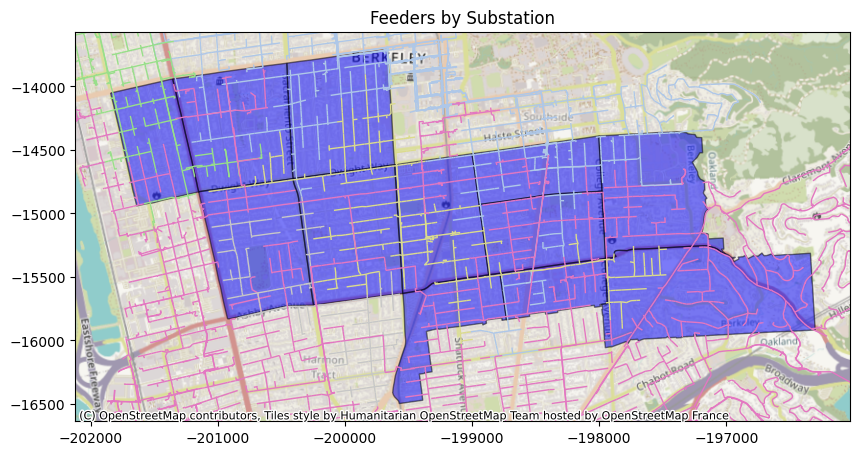

In [ ]:
print(feederinfo.crs)
census_tracts_alameda = census_tracts_alameda.to_crs(epsg=3310) # EPSG=3310 CRS is a California-specific projection
feederinfo = feederinfo.to_crs(epsg=3310)

# Define the projection for geographic coordinates and for EPSG=3310
proj_latlon = Proj(proj='latlong', datum='WGS84')
proj_3310 = Proj(init='epsg:3310')

# Define the bounding box for the Bay Area in geographic coordinates
# bay_area_bounds_latlon = (-123.0, 37.0, -121.5, 38.5)
bay_area_bounds_latlon = (-123.0, 36.8, -121.5, 38.9)

bay_area_bounds_3310 = transform(proj_latlon, proj_3310, *bay_area_bounds_latlon)

# Set the bounds for the Bay Area in the EPSG=3310 coordinate system
# These would need to be calculated based on the conversion from geographic coordinates
minx, miny, maxx, maxy = bay_area_bounds_3310

# Define the projections
p1 = Proj(init='epsg:3310')  # The projection of your data
p2 = Proj(proj='latlong', datum='WGS84')  # Geographic coordinate system

# Function to transform coordinates
def transform_coordinates(x, y):
    lon, lat = transform(p1, p2, x, y)
    return lon, lat

# with ctx basemap
fig, ax = plt.subplots(figsize=(10, 10))
census_tracts_alameda.plot(ax=ax, color='blue', edgecolor='black', alpha=0.2)
ctx.add_basemap(ax, crs=census_tracts_alameda.crs.to_string()) # Add basemap first so that the plot preview context stays around Alameda

feederinfo.plot(ax=ax, column='Substation', cmap='tab20', linestyle='-', linewidth=1)

# Customize and show plot
plt.title('Feeders by Substation')
plt.show()

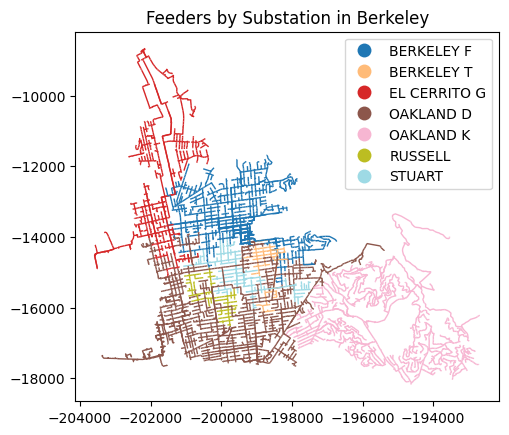

In [ ]:

# Assuming feederinfo is already loaded and properly projected
# Define the bounding box using the x and y limits
bounding_box = box(-202121.33339636363, -16636.071665242685, -196024.4429957341, -13569.872735024988)

# Filter the GeoDataFrame to only include feeders within the bounding box
visible_feeders = feederinfo[feederinfo.intersects(bounding_box)]

# Now you can plot or analyze just the visible feeders
# For example, plotting them:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
visible_feeders.plot(ax=ax, column='Substation', cmap='tab20', linestyle='-', linewidth=1, legend=True)
plt.title('Feeders by Substation in Berkeley')
plt.show()

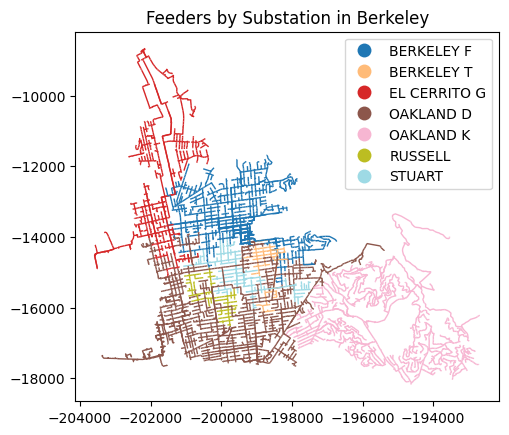

In [ ]:

# Assuming feederinfo is already loaded and properly projected
# Define the bounding box using the x and y limits
bounding_box = box(-202121.33339636363, -16636.071665242685, -196024.4429957341, -13569.872735024988)

# Filter the GeoDataFrame to only include feeders within the bounding box
visible_feeders = feederinfo[feederinfo.intersects(bounding_box)]

# Now you can plot or analyze just the visible feeders
# For example, plotting them:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
visible_feeders.plot(ax=ax, column='Substation', cmap='tab20', linestyle='-', linewidth=1, legend=True)
# ctx.add_basemap(ax, crs=top_feeders.crs.to_string(), source=ctx.providers.Esri.WorldStreetMap)
plt.title('Feeders by Substation in Berkeley')
plt.show()

In [ ]:
import geopandas as gpd

# Selecting the top 5 feeders with the most customers
top_feeders = feederinfo.nlargest(5, 'TotCust')

# Ensure both GeoDataFrames are using the same CRS
top_feeders = top_feeders.to_crs(census_tracts.crs)

print("*****")
top_feeders.head()

*****


,Substation,FeederID,Feeder_Name,Nominal_Voltage,Load_Profile_Redaction,ResCust,ComCust,IndCust,AgrCust,OthCust,...,Show,VOLTNUM,Shape_Length,geometry,TotCust,ResCust_pct,ComCust_pct,IndCust_pct,AgrCust_pct,OthCust_pct
1616,MESA,182821103,MESA 1103,12kV,No,7201,402,103,97,11,...,1,12.0,216865.825040,"MULTILINESTRING ((-120.49226 35.01004, -120.49...",7814,92.155106,5.144612,1.318147,1.241362,0.140773
2824,OAKLAND J,12091116,OAKLAND J 1116,12kV,No,7184,388,97,0,19,...,1,12.0,42573.475124,"MULTILINESTRING ((-122.20841 37.77394, -122.20...",7688,93.444329,5.046826,1.261707,0.000000,0.247138
2051,MISSION (X),22011113,MISSION (X) 1113,12kV,No,6956,374,127,0,15,...,1,12.0,17748.348208,"MULTILINESTRING ((-122.43849 37.77005, -122.43...",7472,93.094218,5.005353,1.699679,0.000000,0.200749
667,OAKLAND X,12541115,OAKLAND X 1115,12kV,No,7003,391,64,0,13,...,1,12.0,26953.619675,"MULTILINESTRING ((-122.25017 37.82661, -122.25...",7471,93.735778,5.233570,0.856646,0.000000,0.174006
1881,SF H,22101105,SF H 1105,12kV,No,6721,528,79,0,37,...,1,12.0,50947.038583,"MULTILINESTRING ((-122.45843 37.69820, -122.45...",7365,91.255940,7.169043,1.072641,0.000000,0.502376


In [ ]:
# Perform a spatial join
feeders_with_tracts = gpd.sjoin(top_feeders, census_tracts, how="left", op='intersects')

print("top_feeder: ", top_feeders.columns)
print("census_tracts: ", census_tracts.columns)
print("feeders_with_tracts: ", feeders_with_tracts.columns)

matches = feeders_with_tracts[['Substation', 'FeederID', 'TotCust', 'NAMELSAD', 'geometry']]

# feeders_with_tracts.head()
# matches['Substation'].unique()
matches.head()

/Users/ana/Library/Python/3.11/lib/python/site-packages/IPython/core/interactiveshell.py:3493: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


top_feeder:  Index(['Substation', 'FeederID', 'Feeder_Name', 'Nominal_Voltage',
       'Load_Profile_Redaction', 'ResCust', 'ComCust', 'IndCust', 'AgrCust',
       'OthCust', 'Existing_DG', 'Queued_DG', 'Total_DG', 'Show', 'VOLTNUM',
       'Shape_Length', 'geometry', 'TotCust', 'ResCust_pct', 'ComCust_pct',
       'IndCust_pct', 'AgrCust_pct', 'OthCust_pct'],
      dtype='object')
census_tracts:  Index(['STATEFP', 'COUNTYFP', 'TRACTCE', 'GEOID', 'GEOIDFQ', 'NAME',
       'NAMELSAD', 'MTFCC', 'FUNCSTAT', 'ALAND', 'AWATER', 'INTPTLAT',
       'INTPTLON', 'geometry'],
      dtype='object')
feeders_with_tracts:  Index(['Substation', 'FeederID', 'Feeder_Name', 'Nominal_Voltage',
       'Load_Profile_Redaction', 'ResCust', 'ComCust', 'IndCust', 'AgrCust',
       'OthCust', 'Existing_DG', 'Queued_DG', 'Total_DG', 'Show', 'VOLTNUM',
       'Shape_Length', 'geometry', 'TotCust', 'ResCust_pct', 'ComCust_pct',
       'IndCust_pct', 'AgrCust_pct', 'OthCust_pct', 'index_right', 'STATEFP',
       '

,Substation,FeederID,TotCust,NAMELSAD,geometry
1616,MESA,182821103,7814,Census Tract 124.05,"MULTILINESTRING ((-120.49226 35.01004, -120.49..."
1616,MESA,182821103,7814,Census Tract 124.03,"MULTILINESTRING ((-120.49226 35.01004, -120.49..."
1616,MESA,182821103,7814,Census Tract 123.06,"MULTILINESTRING ((-120.49226 35.01004, -120.49..."
1616,MESA,182821103,7814,Census Tract 124.04,"MULTILINESTRING ((-120.49226 35.01004, -120.49..."
1616,MESA,182821103,7814,Census Tract 124.06,"MULTILINESTRING ((-120.49226 35.01004, -120.49..."


IndexError: list index out of range

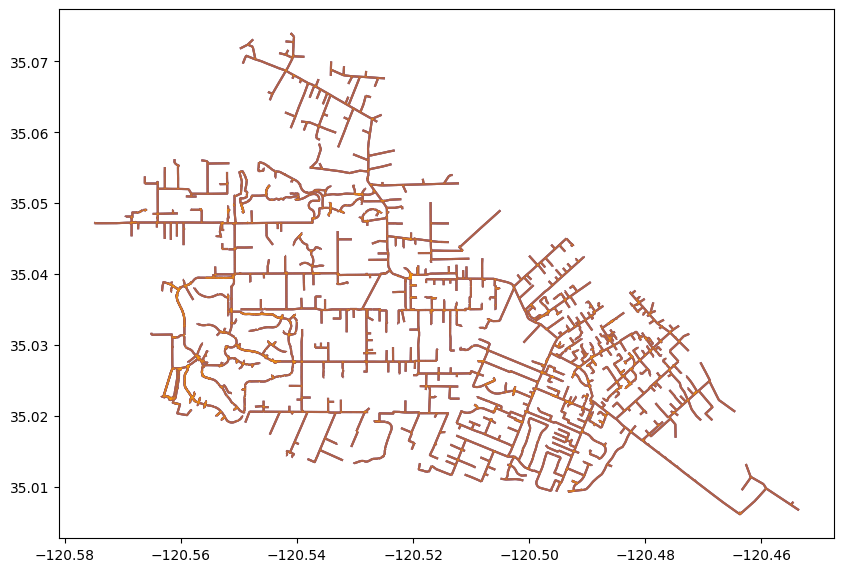

In [ ]:
# Plotting the feeders
fig, ax = plt.subplots(figsize=(10, 10))  # Create a plot with custom size
# census_tracts.plot(ax=ax, color='lightblue')  # Plot the census tracts as a background
for i, feeder in enumerate(matches.geometry):
    gpd.GeoDataFrame({'geometry': [feeder]}, crs=top_feeders.crs).plot(ax=ax, color=colors[i], alpha=0.5, markersize=100)
ctx.add_basemap(ax, crs=matches.crs.to_string()) # Add basemap first so that the plot preview context stays around Bay

# Focusing on the Bay Area, set bounds (these coordinates might need adjusting)
ax.set_xlim(bounds_bay_area_x)
ax.set_ylim(bounds_bay_area_y)

plt.title('Top 5 Feeders with Most Customers')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [ ]:
# fig, ax = plt.subplots(figsize=(10, 10))

# # Define a color map for visual diversity
# colors = ['red', 'green', 'blue', 'purple', 'orange']

# for i, feeder in enumerate(top_feeders.geometry):
#     gpd.GeoDataFrame({'geometry': [feeder]}, crs=top_feeders.crs).plot(ax=ax, color=colors[i], alpha=0.5, markersize=100)

# # Adding a basemap with contextily
# ctx.add_basemap(ax, crs=top_feeders.crs.to_string(), source=ctx.providers.Esri.WorldStreetMap, zoom=18)

# # Focusing on the Bay Area, set bounds (these coordinates might need adjusting)
# ax.set_xlim([-122.6, -122.0])
# ax.set_ylim([37.5, 38.0])

# plt.title('Top 5 Feeders with Most Customers')
# plt.show()


In [ ]:
# Grouping by Substation and aggregating
aggregated_data = matches.groupby(['Substation', 'FeederID']).agg({
    'NAMELSAD': lambda x: list(set(x)),  # List of unique GEOIDs
    'TotCust': 'sum',  # Sum of TotCust for all feeders under each substation
    'geometry': 'first'
}).reset_index()

# Adding columns to count the number of unique GEOIDs and FeederIDs
aggregated_data['Unique_NAMELSAD_Count'] = aggregated_data['NAMELSAD'].apply(len)

aggregated_data.head()


,Substation,FeederID,NAMELSAD,TotCust,geometry,Unique_NAMELSAD_Count
0,MESA,182821103,"[Census Tract 124.03, Census Tract 123.06, Cen...",46884,"MULTILINESTRING ((-120.49226 35.01004, -120.49...",6
1,MISSION (X),22011113,"[Census Tract 167, Census Tract 163, Census Tr...",89664,"MULTILINESTRING ((-122.43849 37.77005, -122.43...",12
2,OAKLAND J,12091116,"[Census Tract 4070, Census Tract 4068, Census ...",92256,"MULTILINESTRING ((-122.20841 37.77394, -122.20...",12
3,OAKLAND X,12541115,"[Census Tract 4050, Census Tract 4051, Census ...",97123,"MULTILINESTRING ((-122.25017 37.82661, -122.25...",13
4,SF H,22101105,"[Census Tract 6005.01, Census Tract 6005.02, C...",162030,"MULTILINESTRING ((-122.45843 37.69820, -122.45...",22


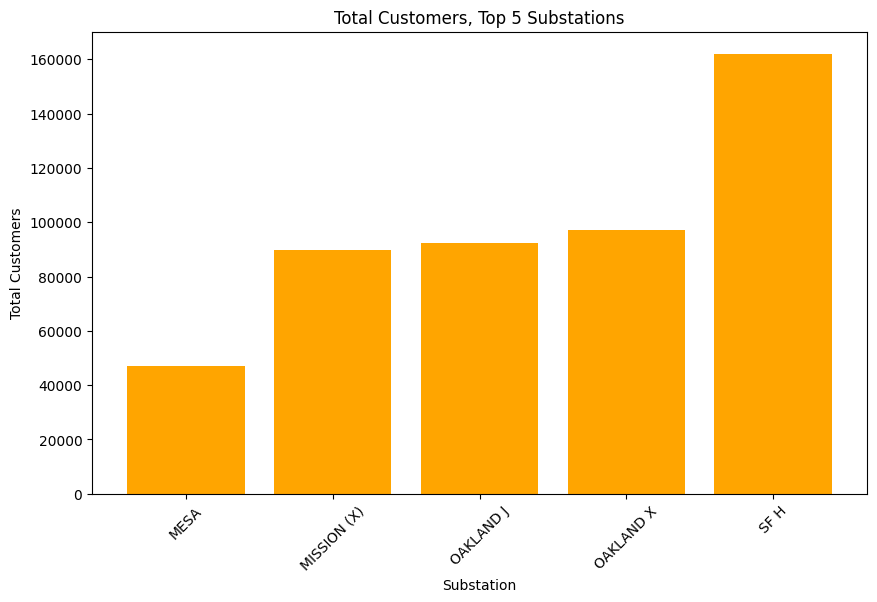

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

plt.figure(figsize=(10, 6))
plt.bar(aggregated_data['Substation'], aggregated_data['TotCust'], color='orange')
plt.xlabel('Substation')
plt.ylabel('Total Customers')
plt.title('Total Customers, Top 5 Substations')
plt.xticks(rotation=45)
plt.show()


In [ ]:


# print(feeders_with_tracts)

# Calculate the centroid for each feeder
top_feeders['centroid'] = top_feeders.geometry.centroid

# Use the centroid to perform a spatial join
# This join will find the census tract that contains the centroid of each feeder
primary_tract = gpd.sjoin(top_feeders.set_geometry('centroid'), census_tracts, how="left", op='contains')

# Select relevant columns to display
result = primary_tract[['Feeder_Name', 'TotCust', 'GEOID', 'NAME']]
# print(result)


/var/folders/gr/g6k4s8t13n98c8bw4ywdpxrr0000gn/T/ipykernel_46471/3536181267.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  top_feeders['centroid'] = top_feeders.geometry.centroid
/Users/ana/Library/Python/3.11/lib/python/site-packages/IPython/core/interactiveshell.py:3493: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


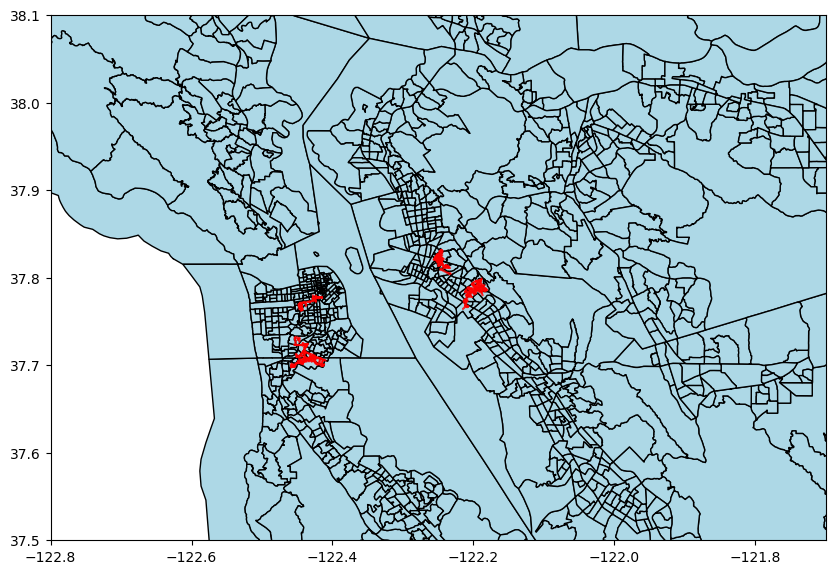

In [ ]:

fig, ax = plt.subplots(figsize=(10, 10))
census_tracts.plot(ax=ax, edgecolor='black', facecolor='lightblue', linewidth=1)
top_feeders.plot(ax=ax, color='red', markersize=5)
# Focusing on the Bay Area, set bounds (these coordinates might need adjusting)
ax.set_xlim(bounds_bay_area_x)
ax.set_ylim(bounds_bay_area_y)

plt.show()

In [ ]:
aggregated_data.head()

print("Number of geometries to plot:", len(aggregated_data.geometry))
# print("Number of available colors:", len(colors))

filtered_data.head()

Number of geometries to plot: 5


,Substation,FeederID,NAMELSAD,TotCust,geometry,Unique_NAMELSAD_Count
1,MISSION (X),22011113,"[Census Tract 167, Census Tract 163, Census Tr...",89664,"MULTILINESTRING ((-122.43849 37.77005, -122.43...",12
2,OAKLAND J,12091116,"[Census Tract 4070, Census Tract 4068, Census ...",92256,"MULTILINESTRING ((-122.20841 37.77394, -122.20...",12
3,OAKLAND X,12541115,"[Census Tract 4050, Census Tract 4051, Census ...",97123,"MULTILINESTRING ((-122.25017 37.82661, -122.25...",13
4,SF H,22101105,"[Census Tract 6005.01, Census Tract 6005.02, C...",162030,"MULTILINESTRING ((-122.45843 37.69820, -122.45...",22


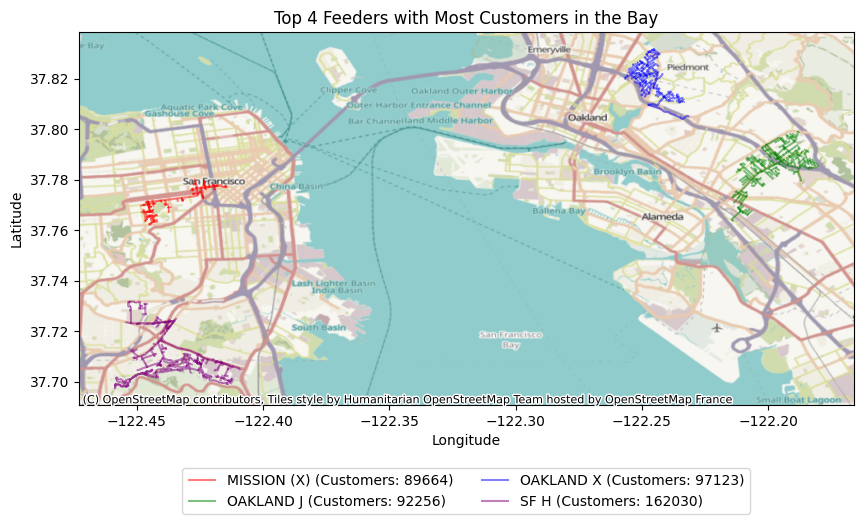

In [ ]:
# Define a color map for visual diversity
colors = ['red', 'green', 'blue', 'purple', 'orange', 'lightblue']
filtered_data = aggregated_data[aggregated_data['Substation'] != 'MESA']

# Calculate the aspect ratio of the bounding box
x_min, x_max = -122.5, -122.15
y_min, y_max = 37.68, 37.9
aspect_ratio = (x_max - x_min) / (y_max - y_min)

fig, ax = plt.subplots(figsize=(10, 10 / aspect_ratio))  # Adjust the figure size based on the aspect ratio
# Uncomment the following line if you want to plot the background census tracts
# census_tracts.plot(ax=ax, color='lightblue')  # Plot the census tracts as a background

# Plot each feeder
for i, (feeder, name, tot_customers) in enumerate(zip(filtered_data.geometry, filtered_data['Substation'], filtered_data['TotCust'])):
    label = f'{name} (Customers: {tot_customers})'
    gpd.GeoDataFrame({'geometry': [feeder]}, crs=matches.crs).plot(ax=ax, color=colors[i], alpha=0.5, markersize=100, label=label)

# Add basemap
ctx.add_basemap(ax, crs=matches.crs.to_string()) # Add basemap first so that the plot preview context stays around Bay
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2)
# ax.set_xlim([-122.5, -122.15])
# ax.set_ylim([37.68, 37.9])

plt.title('Top 4 Feeders with Most Customers in the Bay')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


In [ ]:
from sklearn.neighbors import BallTree
import numpy as np

# Convert geometries to coordinates for nearest neighbor search
def get_coords(geom):
    return np.array(geom.centroid.coords[0])

census_tract_coords = np.array(list(census_tracts.geometry.apply(get_coords)))
feeder_coords = np.array(list(top_feeders.centroid.apply(get_coords)))

# Create a spatial index for the census tracts
tree = BallTree(census_tract_coords, leaf_size=15, metric='haversine')

# Query the closest tract for each feeder
distances, indices = tree.query(feeder_coords, k=1)

# Map the closest tracts back to the feeders
closest_tracts = census_tracts.iloc[indices.flatten()]

# Combine the data
top_feeders['Closest_Tract_GEOID'] = closest_tracts.GEOID.reset_index(drop=True)
top_feeders['Closest_Tract_NAME'] = closest_tracts.NAME.reset_index(drop=True)

# Display the result
print(top_feeders[['Feeder_Name', 'TotCust', 'Closest_Tract_GEOID', 'Closest_Tract_NAME']])

           Feeder_Name  TotCust Closest_Tract_GEOID Closest_Tract_NAME
1616         MESA 1103     7814                 NaN                NaN
2824    OAKLAND J 1116     7688                 NaN                NaN
2051  MISSION (X) 1113     7472                 NaN                NaN
667     OAKLAND X 1115     7471                 NaN                NaN
1881         SF H 1105     7365                 NaN                NaN


/var/folders/gr/g6k4s8t13n98c8bw4ywdpxrr0000gn/T/ipykernel_46471/3259532111.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  feeder_coords = np.array(list(top_feeders.centroid.apply(get_coords)))


In [ ]:
# import geopandas as gpd
# import matplotlib.pyplot as plt
# from shapely.geometry import box

# # Assuming 'feederinfo' and 'census_tracts_alameda' are already loaded and projected to EPSG:3310

# # Define the bounds for the visible area in the plot
# plot_bounds = box(minx, miny, maxx, maxy)

# # Filter 'feederinfo' to include only those features that intersect the plot bounds
# visible_feeders = feederinfo[feederinfo.intersects(plot_bounds)]

# # Plotting
# fig, ax = plt.subplots(figsize=(10, 10))
# census_tracts_alameda.plot(ax=ax, color='blue', edgecolor='black', alpha=0.5)

# # Add basemap
# ctx.add_basemap(ax, crs=census_tracts_alameda.crs.to_string())

# # Plot only visible feeders
# visible_feeders.plot(ax=ax, column='Substation', cmap='tab20', linestyle='-', linewidth=1)

# # Create a custom legend
# from matplotlib.lines import Line2D
# # Create a legend item for each unique substation in the visible feeders
# legend_elements = [Line2D([0], [0], color=plt.cm.tab20(i/float(len(visible_feeders['Substation'].unique()))), lw=4, label=substation) 
#                    for i, substation in enumerate(visible_feeders['Substation'].unique())]
# ax.legend(handles=legend_elements, title="Substation")

# # Set plot limits
# ax.set_xlim(minx, maxx)
# ax.set_ylim(miny, maxy)

# plt.title('Feeders by Substation')
# plt.show()